# <span style="color:#C70039">Analizando los datos adquiridos mediante _dataAnalysis.py_</span>

La siguiente notebook muestra el script _dataAnalysis.py_ versión **SCT-01-RevA**.

La idea detrás de este script es poder analizar los datos que hemos registrado utilizando el script _trainingModule.py_.

Importamos algunas librerias

In [22]:
import os
import numpy as np

import fileAdmin as fa
from utils import filterEEG, segmentingEEG, computeMagnitudSpectrum, computeComplexSpectrum
from utils import plotSpectrum, plotOneSpectrum, plotEEG

Definimos algunas variables

In [23]:
actualFolder = os.getcwd()#directorio donde estamos actualmente. Debe contener el directorio dataset
path = os.path.join(actualFolder,"recordedEEG")

trials = 15
fm = 250.
window = 4 #sec
samplePoints = int(fm*window)
channels = 8
stimuli = 1 #one stimulus

## Chequeando la presencia de ondas Alfa

Cuando una persona en estado de vigilia cierra los ojos se puede ver un aumento de la potencia en las bandas frecuencials que van de los 8Hz a los 12Hz, sobre todo en éste último valor.

Las señales de EEG que utilizaremos a continuación fueron registradas desde una persona que mantuvo sus ojos cerrados por algunos segundos.

#### Cargamos datos

La variable _filenames_ contiene los nombres de los archivos que queremos analizar.

Estos archivos son del tipo _'.mat'_ y fueron creados por el módulo _trainingModule.py._

<span style="color:#008800">**NOTA:** Las señales de EEG fueron registradas utilizando la placa Cyton Board de OpenBCI con 8 canales colocados en la región occipital del cuero cabelludo. Se le pidió a la persona que mantuviera cerrado los ojos durante 5 segundos durante 3 trials seguidos.</span>


In [24]:
subjects = [1] #Un solo sujeto
filenames = ["LucasB-Alfa-Prueba1","LucasB-Alfa-Prueba2","Sujeto1Test1"]
allData = fa.loadData(path = path, filenames = filenames)
names = list(allData.keys())
names

['LucasB-Alfa-Prueba1', 'LucasB-Alfa-Prueba2', 'Sujeto1Test1']

##### Chequeando información

Si hacemos _allData["Sujeto1Test1"].keys()_ veremos cuales son las claves del diccionario que obtenemos al abrir un arhivo _'.mat'_, veamos,

In [25]:
allData["Sujeto1Test1"].keys()

dict_keys(['__header__', '__version__', '__globals__', 'subject', 'date', 'generalInformation', 'stimFrec', 'channels', 'dataShape', 'eeg'])

Si quisieramos ver la información general de la sesión _"Sujeto1Test1"_ hacemos,

In [26]:
#Chequeamos información del registro Sujeto1Test1
print(allData["Sujeto1Test1"]["generalInformation"])
print(allData["Sujeto1Test1"]["dataShape"])

['Estímulo a 30cm. Color rojo. Probando en el taller 6.']
[[  1   8 500   5]]


In [27]:
#Guardo cada prueba en tres archivos diferentes
prueba1 = allData[names[0]]
prueba2 = allData[names[1]]
sujeto1Test1 = allData['Sujeto1Test1']

#### Cargando datos de EEG

Si observamos las claves -keys- de los diccionarios dentro de allData veremos que una de estas es _'eeg'_. Dicha clave contiene la señal de EEG con la forma,
[número estímulo x canales x muestras x trials].

Veamos.

In [28]:
EEGsujeto1Test1 = sujeto1Test1["eeg"]
#[Number of targets, Number of channels, Number of sampling points, Number of trials]

EEGsujeto1Test1.shape

(1, 16, 500, 5)

<span style="color:#C70039">**Importante**</span>: Recordar que la forma (shape) de los datos de EEG están almacenados cómo

    [número de estímulos x cantidad de canales x cantidad muestras x cantidad de trials]

Vemos que para el caso de _EEGsujeto1Test1 = sujeto1Test1["eeg"]_ tenemos,
- 1 clase de estímulo
- 16 canales
- 500 muestras
- 4 trials

### Analizando datos reales

Comparemos con el registro llamado _"LucasB-Alfa-Prueba1"_.

In [29]:
#Chequeamos información del registro prueba 1
print(allData["LucasB-Alfa-Prueba1"]["generalInformation"])

EEGprueba1 = prueba2["eeg"][:,:,:,1:] #descarto trial 1
#[Number of targets, Number of channels, Number of sampling points, Number of trials]

EEGprueba1.shape

['Datos obtenidos desde Cyton.                    Testeando presencia de ondas Alfa']


(1, 8, 1000, 3)

Vemos que para el caso de _EEGprueba1 = prueba1["eeg"][:,:,:,1:]_ tenemos,
- 1 clase de estímulo
- 8 canales
- 1000 muestras
- 3 trials

Graficamos la señal de EEG de los 8 canales sin ningún tipo de filtro.

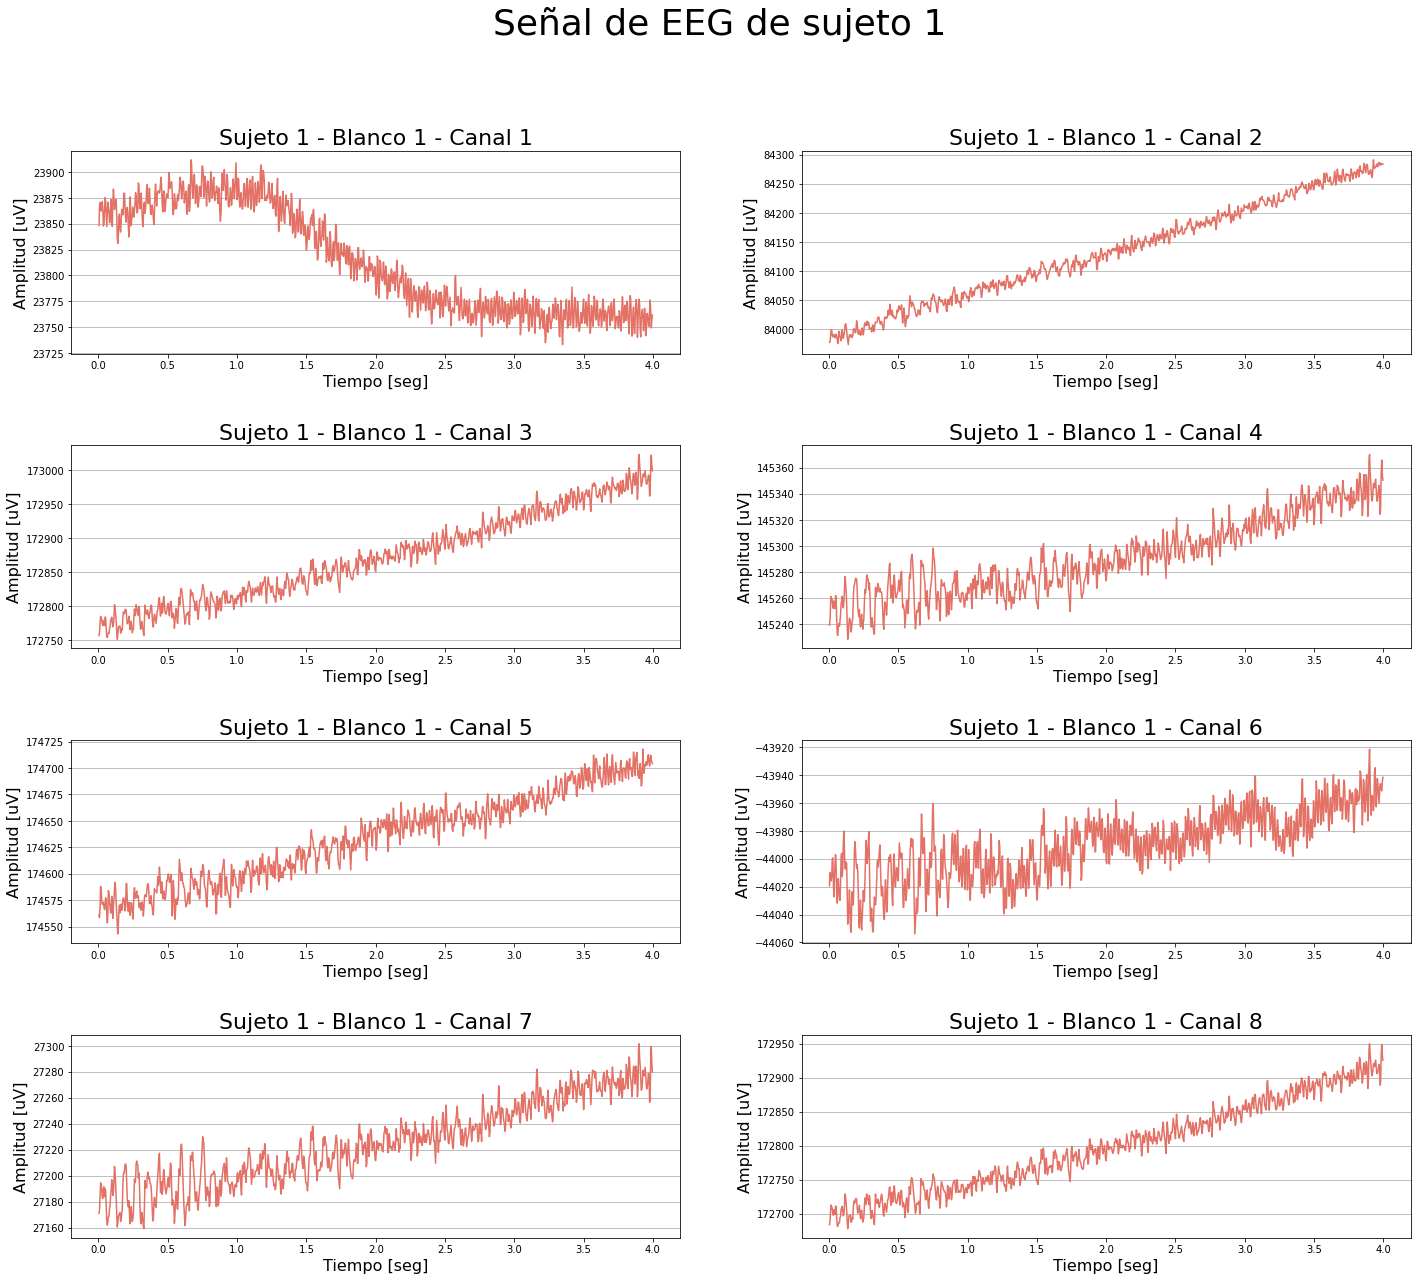

In [30]:
plotEEG(EEGprueba1, sujeto = 1, trial = 1, blanco = 1,
            fm = fm, window = [0,4], rmvOffset = False, save = False, title = "", folder = "figs")

In [31]:
resolution = fm/EEGprueba1.shape[2]

#Cargamos algunos parámetros para filtro y FFT
PRE_PROCES_PARAMS = {
                'lfrec': 7.,
                'hfrec': 28.,
                'order': 4,
                'sampling_rate': fm,
                'window': 4,
                'shiftLen':4
                }


FFT_PARAMS = {
                'resolution': resolution,
                'start_frequency': 0.0,
                'end_frequency': 28.0,
                'sampling_rate': fm
                }

#### Filtrando nuestros datos

Vimos de las gráficas anteriores que la señal de EEG esta muy contaminada, por lo tanto aplicaremos un filtro pasa banda con frecuencias de corte especificadas en _PRE_PROCES_PARAMS_.

In [32]:
prueba1EEGFiltered = filterEEG(EEGprueba1, PRE_PROCES_PARAMS["lfrec"],
                        PRE_PROCES_PARAMS["hfrec"],
                        PRE_PROCES_PARAMS["order"],
                        PRE_PROCES_PARAMS["sampling_rate"])

Graficamos la señal filtrada.

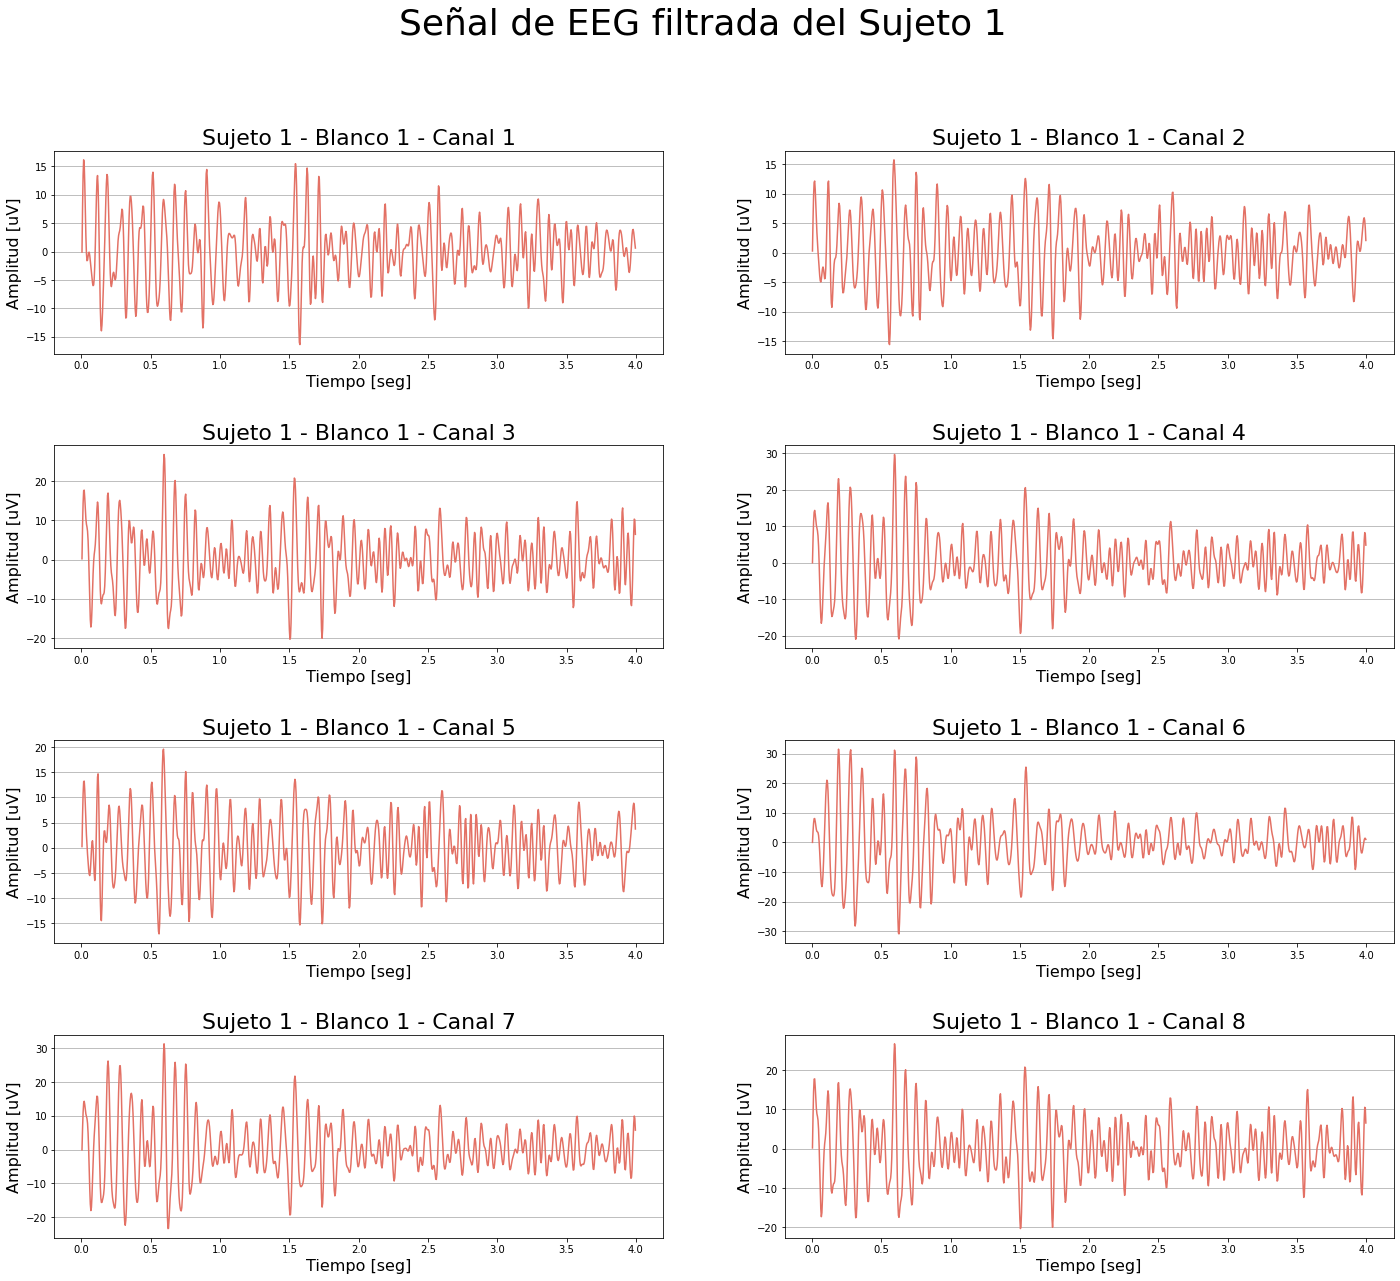

In [33]:
plotEEG(prueba1EEGFiltered, sujeto = 1, trial = 1, blanco = 1,
            fm = fm, window = [0,4], rmvOffset = False, save = False,
            title = "Señal de EEG filtrada del Sujeto 1", folder = "figs")

#### Obteniendo el espectro de la señal

Como ya sabemos, utilizaremos el espectro de la señal de EEG para utilizarlo como las _features_ de nuestros clasificadores.

Para obtener el espectro de la señal hacemos.

In [34]:
#eeg data segmentation
eegSegmented = segmentingEEG(prueba1EEGFiltered, PRE_PROCES_PARAMS["window"],
                             PRE_PROCES_PARAMS["shiftLen"],
                             PRE_PROCES_PARAMS["sampling_rate"])

MSF = computeMagnitudSpectrum(eegSegmented, FFT_PARAMS)
#(113, 8, 1, 3, 1)

##### Graficando el espectro para un canal

A continuación graficaremos el espectro obtenido anteriormente utilizando el canal número 6.

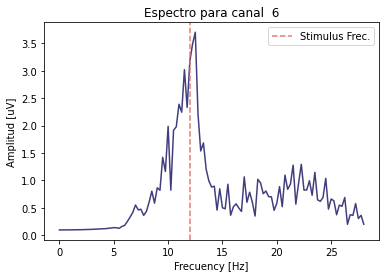

In [35]:
canal = 6
plotOneSpectrum(MSF, resolution, 1, subjects[0], canal-1, [12],
                startFrecGraph = FFT_PARAMS['start_frequency'],
              save = False, title = f"Espectro para canal  {canal}",
              folder = "figs")

**¡Gualá!**

Podemos ver una fuerte actividad en los 12Hz, correspondiente a una fuerte actividad de las áreas del procesamiento visual en la zona occipital debido a una sincronización de las neuronas de esta regíon.

## <span style="color:#C70039">Buscando SSVEPs</span>

Ahora analizaremos otro set de datos en busca de Potenciales Evocados de Estado Estacionario.

#### Cargamos datos

La variable _filenames_ contiene los nombres de los archivos que queremos analizar.

Estos archivos son del tipo _'.mat'_ y fueron creados por el módulo _trainingModule.py._

<span style="color:#2C477E">**NOTA:** Las señales de EEG fueron registradas utilizando la placa Cyton Board de OpenBCI con 8 canales colocados en la región occipital del cuero cabelludo. Se le pidió a la persona que enfocara su mirada sobre un LED a una distancia de aproximadamente 40cm el cual parpadeaba a una cierta frecuencia durante 15 trials. Cada trial estuvo conformado por 4 segundos de estimulación m+as 2 segundos sin estimular. Se realizó el mismo proceso utilizando frecuencias de estimulación del LED de 7Hz, 8Hz y 9Hz.</span>

In [36]:
"""Buscando SSVEPs"""
subjects = [1] #cantidad de sujetos

filenames = ["LucasB-PruebaSSVEPs(5.5Hz)-Num1",
             "LucasB-PruebaSSVEPs(8Hz)-Num1",
             "LucasB-PruebaSSVEPs(9Hz)-Num1"]
allData = fa.loadData(path = path, filenames = filenames)
names = list(allData.keys())

estimuli = ["5.5","8","9"]
frecStimulus = np.array([5.5, 8, 9])

#Chequeamos información del registro de la prueba del estímulo 8hz
print(allData["LucasB-PruebaSSVEPs(8Hz)-Num1"]["generalInformation"])

['Datos desde Cyton. Testeando SSVEPs en 8Hz. Descartar trial 1']


Chequeando cantidad de trials de cada sesión.

In [37]:
for name in names:
    print(f"Cantidad de trials para {name}:",
          allData[name]["eeg"].shape[3])

Cantidad de trials para LucasB-PruebaSSVEPs(5.5Hz)-Num1: 15
Cantidad de trials para LucasB-PruebaSSVEPs(8Hz)-Num1: 16
Cantidad de trials para LucasB-PruebaSSVEPs(9Hz)-Num1: 16


#### Uniendo los datos en un solo archivo



In [38]:
def joinData(allData, stimuli = 4, channels = 8, samples = 1000, trials = 15):
    joinedData = np.zeros((stimuli, channels, samples, trials))
    for i, sujeto in enumerate(allData):    
        joinedData[i] = allData[sujeto]["eeg"][0,:,:,:trials]
        
    return joinedData

joinedData = joinData(allData, stimuli = 3, channels = 8, samples = 1000, trials = 15)

joinedData.shape

(3, 8, 1000, 15)

##### Filtramos nuestra señal de EEG

Debemos filtrar nuestros datos de EEG antes de poder analizarlos.

In [39]:
resolution = fm/joinedData.shape[2]

PRE_PROCES_PARAMS = {
                'lfrec': 5.,
                'hfrec': 17.,
                'order': 4,
                'sampling_rate': fm,
                'window': 4,
                'shiftLen':4
                }

FFT_PARAMS = {
                'resolution': resolution,
                'start_frequency': 0.0,
                'end_frequency': 17.0,
                'sampling_rate': fm
                }

eegFiltered = filterEEG(joinedData, PRE_PROCES_PARAMS["lfrec"],
                        PRE_PROCES_PARAMS["hfrec"],
                        PRE_PROCES_PARAMS["order"],
                        PRE_PROCES_PARAMS["sampling_rate"])

##### Graficamos el EEG

A continuación graficamos los 8 canales del EEG para cada sesión.

Nota: Recordar que _cada sesión_ es un _estímulo diferente_.

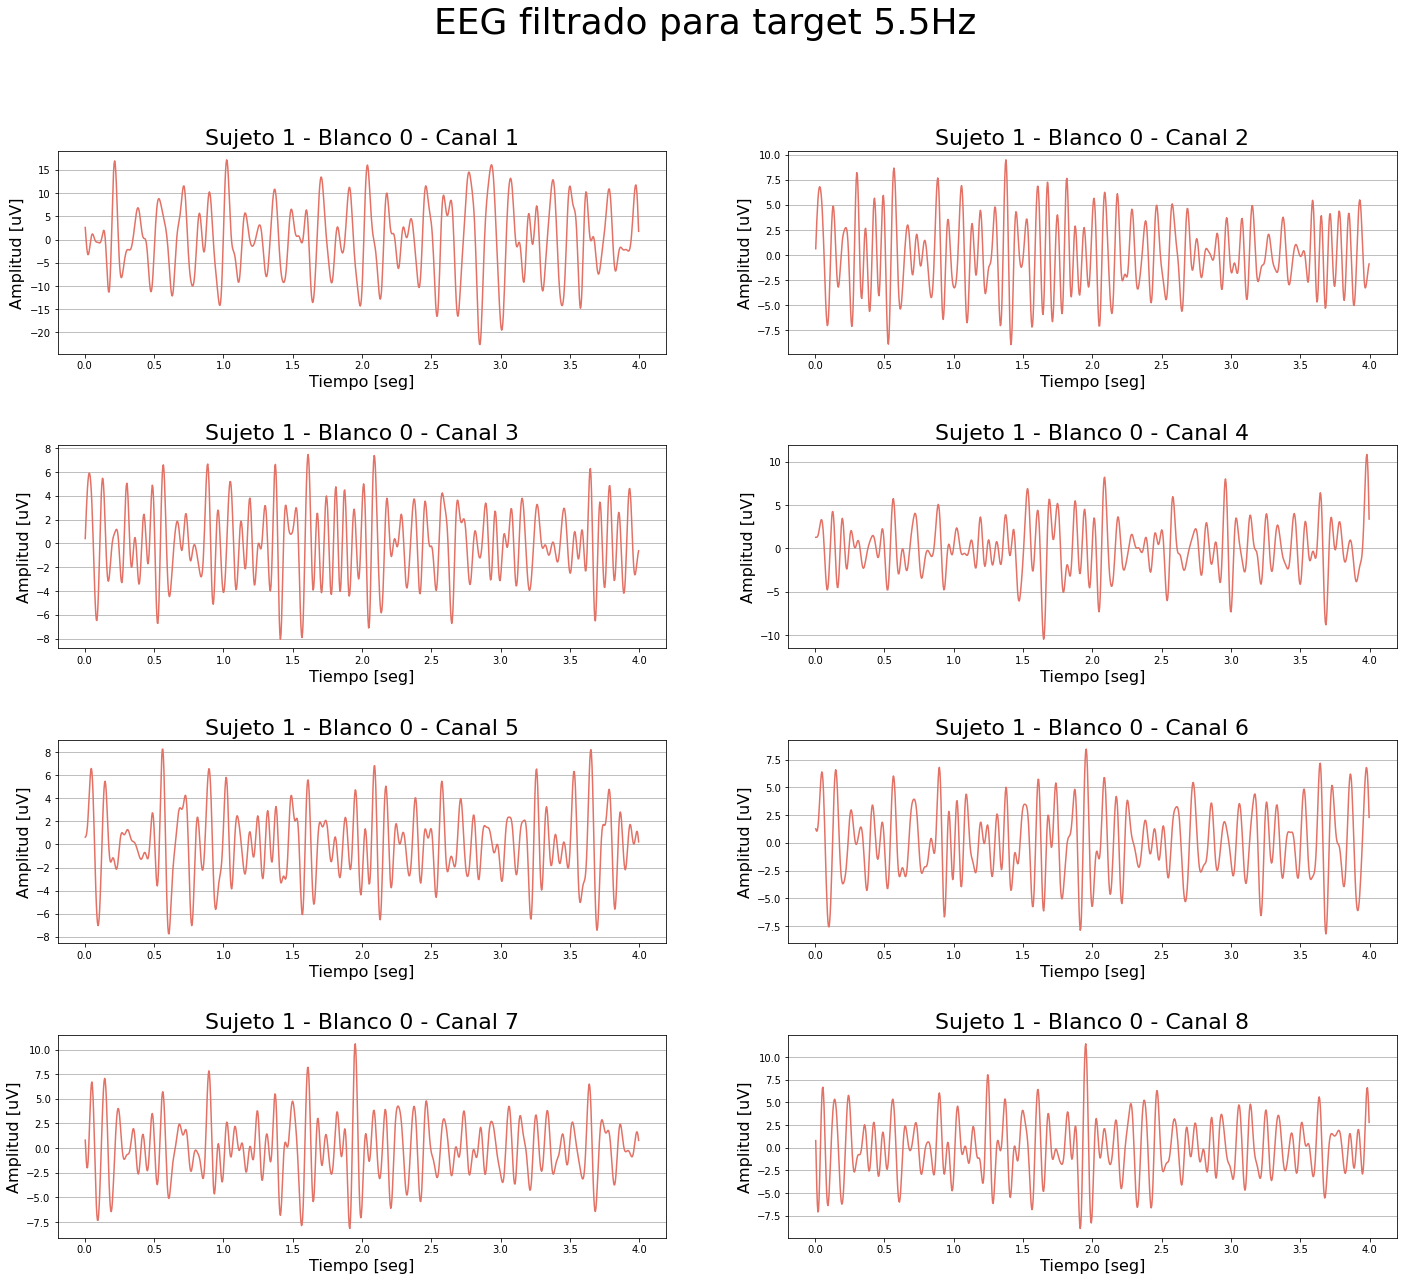

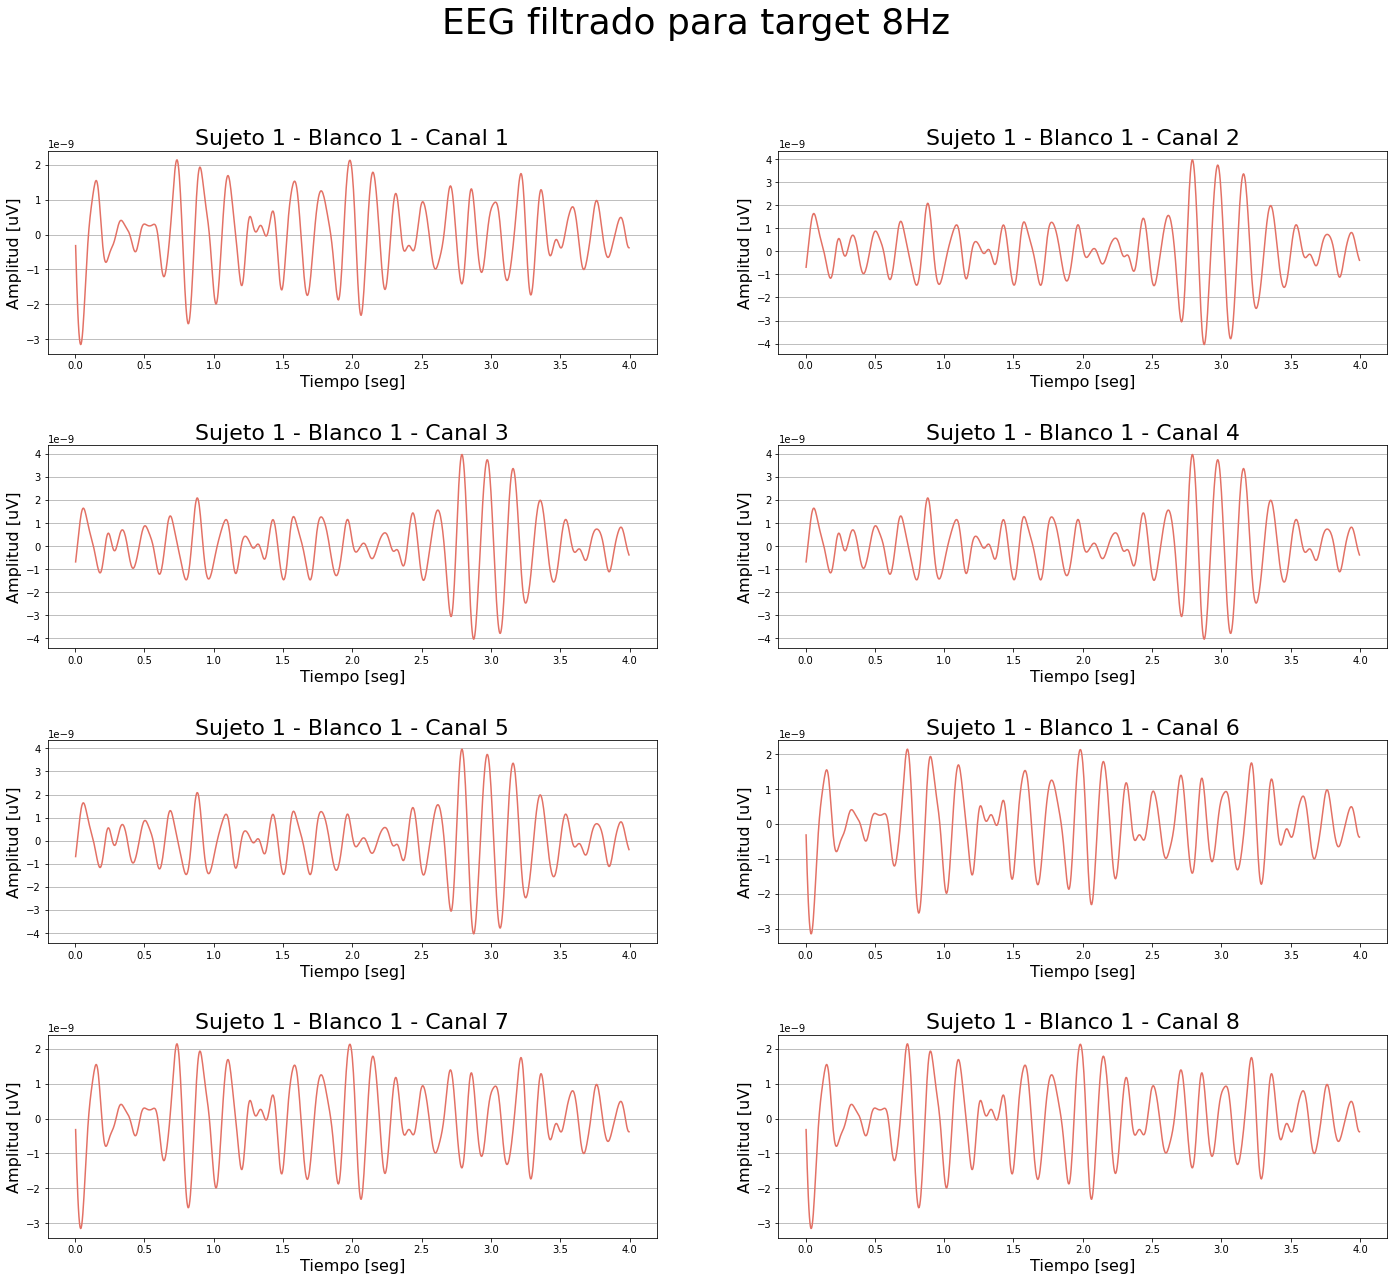

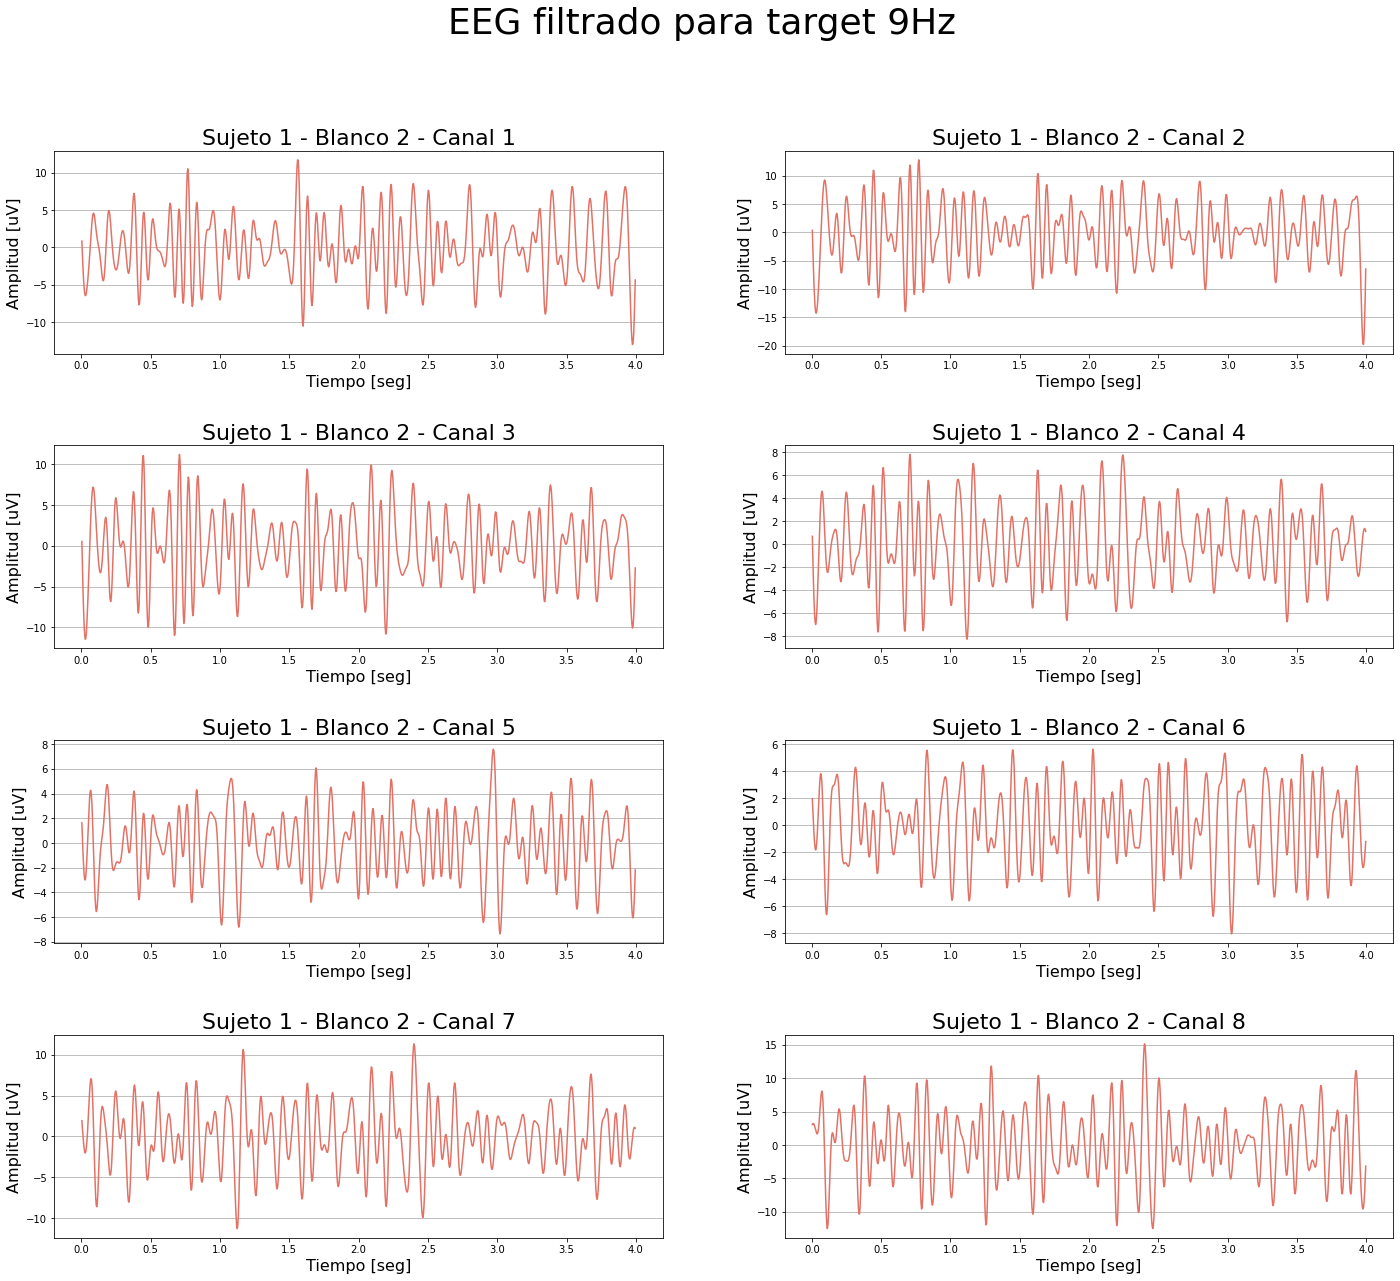

In [40]:
#Graficamos el EEG de cada canal para cada estímulo
trial = 10
for stimulus in range(len(frecStimulus)):
    plotEEG(eegFiltered, sujeto = 1, trial = 10, blanco = stimulus,
            fm = fm, window = [0,4], rmvOffset = False, save = False,
            title = f"EEG filtrado para target {estimuli[stimulus]}Hz",
            folder = "figs")

##### Obteniendo el espectro de Fourier

El paso siguiente una vez que tenemos nuestra señal filtrada es obtener su espectro a partir de la FFT.

Veamos.

In [41]:
#eeg data segmentation
eegSegmented = segmentingEEG(eegFiltered, PRE_PROCES_PARAMS["window"],
                             PRE_PROCES_PARAMS["shiftLen"],
                             PRE_PROCES_PARAMS["sampling_rate"])

magnitudFeatures = computeMagnitudSpectrum(eegSegmented, FFT_PARAMS)

#### Graficando el espectro

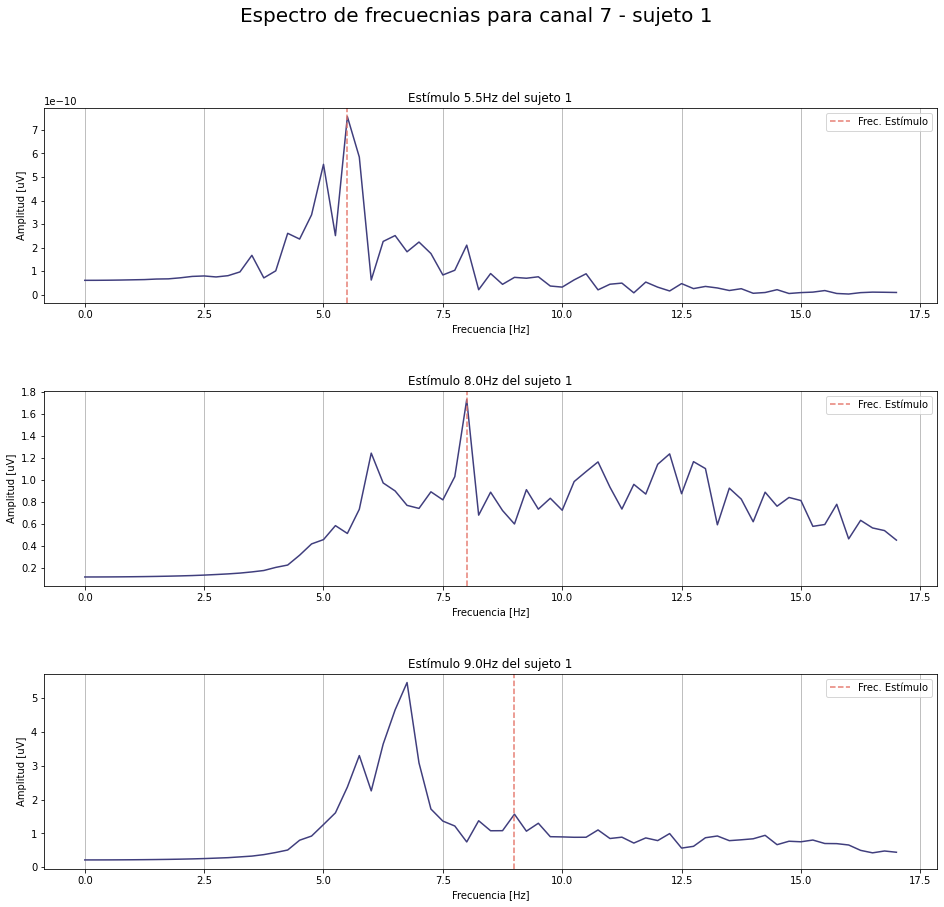

In [42]:
cantidadTargets = 3
plotSpectrum(magnitudFeatures, resolution, cantidadTargets,
             subjects[0], 7, frecStimulus,
              startFrecGraph = FFT_PARAMS['start_frequency'],
              save = False, title = "", folder = "figs",
              rows = 1, columns = 3)

#### Resultados

Vemos que en el caso de los estímulos de 5.5Hz y 8Hz se distingue claramente un pico en dichas frecuencias, demostrando así que los estímulos evocaron correctamente.

No obsatante, en el caso del estímulo de 9Hz esto no sucede.